In [1]:
# Is an ARIMA(0,1,2) model suitable for the widget_sales dataset ?

# Import time module
from datetime import datetime as dt

# Record start time
start = dt.now()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("data/widget_sales.csv")
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


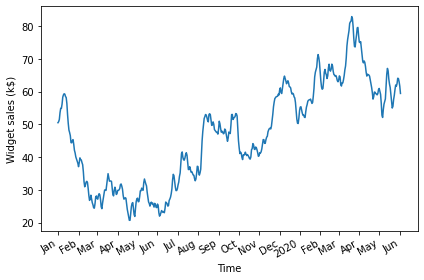

In [3]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
     '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
# Test for stationerity using agugented Dickey Fuller algorithm
adfuller_result = adfuller(df['widget_sales'])

print(f'ADF Statistic: {adfuller_result[0]}')
print(f'P-value: {adfuller_result[1]}')

ADF Statistic: -1.5121662069359036
P-value: 0.527484535227261


In [5]:
# The process is not statitionery, so we apply differentiation to make it stationery
df_diff = np.diff(df['widget_sales'], n=1)

In [6]:
# Test for stationerity using agugented Dickey Fuller algorithm
adfuller_result = adfuller(df_diff)

print(f'ADF Statistic: {adfuller_result[0]}')
print(f'P-value: {adfuller_result[1]}')

ADF Statistic: -10.57665778034196
P-value: 7.076922818587193e-19


In [7]:
# We have a p-value smaller than 0.05 and a large negative ADF statistic, our series is stationary
# d = 1 (Number of rounds of differencing to make our data stationery)
d = 1

In [8]:
# Next we separate our data into train and test sets. 
# For model fitting, we will reserve 50 for test data and leave the rest for training data

train = df['widget_sales'][:-50].copy()
test = df['widget_sales'][-50:].copy()

print(len(train))
print(len(test))

450
50


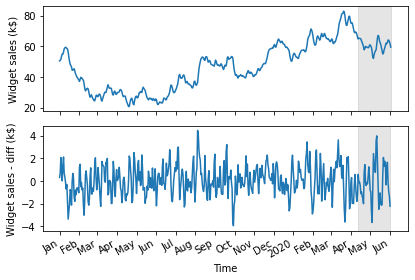

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')

ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec', 
     '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# use optimize_ARIMA function to fit the many ARIMA(p,d,q) models

from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []

    # Iterate over each unique (p,q) combination. The use of tqdm_notebook will display a progress bar
    for order in tqdm(order_list):
        try:
            # Fit an ARIMA(p,d,q) model using the SARIMAX function.
            # We specify simple_differencing=False, to prevent differencing.
            # We also specify disp=False to avoid printing convergence messages to the console
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
# We define a list of possible values for the orders p and q.

from itertools import product

ps = range(0, 4, 1)
qs = range(0, 4, 1)
order_list = list(product(ps, qs))

In [12]:
# Run the optimize_ARIMA function to obtain the model with the lowest AIC.
import warnings
warnings.filterwarnings('ignore')

result_df = optimize_ARIMA(train, order_list, d)
result_df

,"(p,d,q)",AIC
0,"(3, 3)",1251.429287
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643258


In [13]:
# From the returned DataFrame, an ARIMA(3,1,3) model seems to be the most suitable, so fit it on the training set
# The expected ARIMA(0, 1, 2) model was second.

model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp = False)
residuals = model_fit.resid

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.715
Date:                Wed, 27 Sep 2023   AIC                           1251.429
Time:                        10:30:54   BIC                           1280.178
Sample:                             0   HQIC                          1262.761
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3638      0.064     21.252      0.000       1.238       1.490
ar.L2         -1.3537      0.065    -20.904      0.000      -1.481      -1.227
ar.L3          0.3518      0.064      5.487      0.0

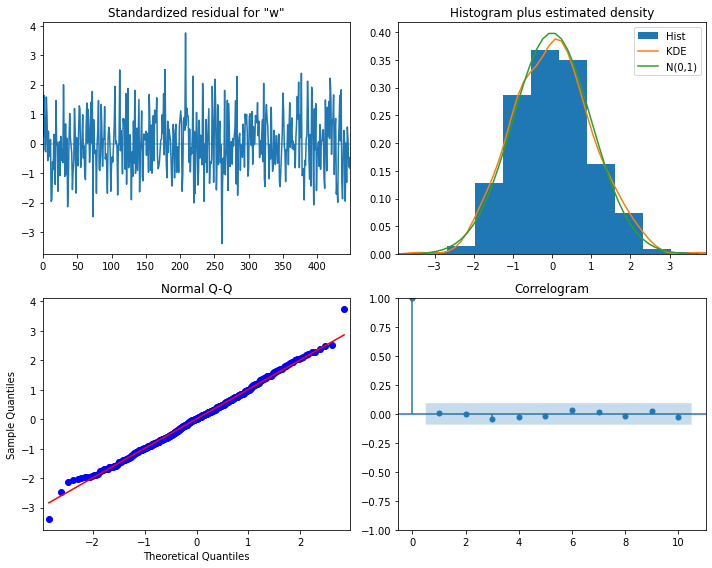

In [14]:
model_fit.plot_diagnostics(figsize=(10,8))

plt.tight_layout()

In [15]:
# From the the top-left plot, the variance is not constant, which is a discrepancy in comparison to white noise. 
# At the top right is the distribution of the residuals, we can see what is close to a normal distribution. 
# The Q-Q plot displays a line that is fairly straight, meaning that the residuals’ distribution is close to a normal distribution. 
# Finally, the correlogram at the bottom right, shows no significant coefficients after lag 0, just like white noise.

# Thus, from a qualitative standpoint, it seems that our residuals are close to white noise, which is a good sign, 
# as it means that the model’s errors are random.

In [16]:
# Finally apply the Ljung-Box test to quantitatively assess whether our residuals are indeed uncorrelated.
from statsmodels.stats.diagnostic import acorr_ljungbox

lbvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)
lbvalue.columns = ['stat', 'p-value']
lbvalue

,stat,p-value
1,0.017988,0.893308
2,0.044773,0.977862
3,0.241782,0.970578
4,0.263859,0.992026
5,0.284260,0.997929
6,0.705325,0.994375
7,0.829198,0.997134
8,0.904225,0.998784
9,0.954139,0.999536
10,1.004260,0.999824


In [17]:
# p-values are all greater than 0.05, so the residuals are NOT correlated just like white noise.
# As a benchmark for our model, we use the mean & last value. 

In [18]:
#import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
    
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    elif method == 'MA':
        pred_MA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,2))
            res = model.fit(disp=False)
            #res = model.fit(disp=False, method_kwargs={"warn_convergence": False})
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)
        return pred_MA
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            
            res = model.fit(disp=False)
            #res = model.fit(disp=False, method_kwargs={"warn_convergence": False})
            
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
        return pred_ARIMA

In [19]:
test = pd.DataFrame(test)
test.columns = ['widget_sales']
test.head()

,widget_sales
450,64.736005
451,65.316972
452,65.172070
453,65.075506
454,64.703173


In [20]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last')
#pred_MA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'MA')
pred_ARIMA = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test['pred_mean'] = pred_mean
test['pred_last_value'] = pred_last_value
#test['pred_MA'] = pred_MA
test['pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.810685
451,65.316972,45.472231,65.906136,64.715972
452,65.172070,45.558754,65.316972,66.242739
453,65.075506,45.558754,65.316972,66.609343
454,64.703173,45.644943,65.075506,64.993540


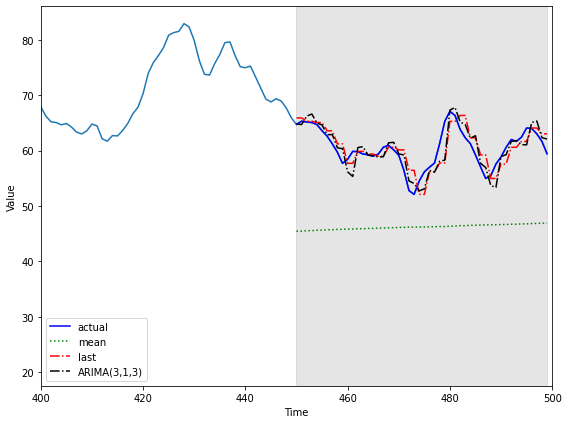

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(df['widget_sales'])
ax.plot(test['widget_sales'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARIMA'], 'k-.', label='ARIMA(3,1,3)')
ax.legend(loc=3)

ax.set_xlabel('Time')
ax.set_ylabel('Value')

ax.axvspan(450, 499, color='#808080', alpha=0.2)

ax.set_xlim(400, 500)  #Zoom in on the testing period

fig.autofmt_xdate
plt.tight_layout()

In [22]:
# Quantify error using the mean Absolute Error (MAE)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) 

In [23]:
mae_mean = mae(test['widget_sales'], test['pred_mean'])
mae_last = mae(test['widget_sales'], test['pred_last_value'])
mae_ARIMA = mae(test['widget_sales'], test['pred_ARIMA'])

print(mae_mean, mae_last, mae_ARIMA)

14.220336729946744 1.819226540180243 1.5728058293105591


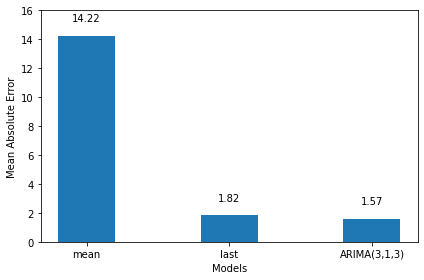

In [24]:
fig, ax = plt.subplots()

x = ['mean', 'last', 'ARIMA(3,1,3)']
y = [mae_mean, mae_last, mae_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('Mean Absolute Error')
ax.set_ylim(0, 16)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

In [25]:
# ARIMA(3,1,3) has a better(lower) Mean Absolute Error than the MA(2.32) for the same widget_sales dataset

In [26]:
# record end time

end = dt.now()
elapsed = end-start
print("The program took: %02d:%02d:%02d:%02d" % (elapsed.days, elapsed.seconds // 3600, elapsed.seconds // 60 % 60, elapsed.seconds % 60))

The program took: 00:00:01:00
